# Set up

In [358]:
import pandas as pd
import patsy
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math

# Getting data

In [162]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [163]:
element_gameweek_df = pd.read_csv(file_name)

In [164]:
current_event = 20

In [165]:
last_train_event = 15

In [166]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [167]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [168]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [169]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [170]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Building model

In [171]:
formula = \
'total_points ~ C(team) + C(opposition_team) + C(element_type) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [172]:
print(formula)

total_points ~ C(team) + C(opposition_team) + C(element_type) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_missed_element +

In [173]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [174]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

In [200]:
estimator = RandomForestRegressor(
    n_estimators=400,
    min_samples_leaf=0.0146,
    max_features=0.9)

selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector.fit(
    X,
    y.ravel()
)

Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                      max_depth=None, max_features=0.9,
                                      max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=0.0146,
                                      min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=400, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [201]:
sum(selector.support_)

30

In [323]:
selector.support_

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False, False,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True])

In [202]:
list(pd.Series(X.design_info.column_names)[selector.support_])

['C(team)[T.12]',
 'C(element_type)[T.2]',
 'was_home',
 'is_late',
 'value',
 'rolling_avg_total_points_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_attempt_element',
 'rolling_avg_yellow_cards_element',
 'rolling_avg_minutes_element_p3',
 'rolling_avg_total_points_element_p3',
 'rolling_avg_goals_scored_opposition_team',
 'rolling_avg_goals_conceded_opposition_team

In [203]:
X_sel = X[:,selector.support_]
X_train_sel = X_train[:,selector.support_]
X_test_sel = X_test[:,selector.support_]

## Tuning model

### GP tuner

In [208]:
space  = [
    Real(0.01, 0.02, 'log-uniform', name='min_samples_leaf'),
    Real(0.2, 0.9, 'uniform', name='max_features'),
]

In [209]:
gp_model = RandomForestRegressor(
    n_estimators=400
)

@use_named_args(space)
def objective(**params):
    gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            gp_model,
#             X,
            X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [210]:
res_gp_arr = []
for i in range(1, 6):
    print('minimisation iteration', i)
    res_gp = gp_minimize(objective, space, n_calls=50, verbose=2)
    res_gp_arr.append(res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.8101
Function value obtained: 9.3113
Current minimum: 9.3113
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.2247
Function value obtained: 9.3063
Current minimum: 9.3063
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.9877
Function value obtained: 9.3334
Current minimum: 9.3063
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.3797
Function value obtained: 9.2894
Current minimum: 9.2894
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.6226
Function value obtained: 9.3162
Current minimum: 9.2894
Iteration 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 5.5468
Function value obtained: 9.2892
Current minimum: 9.2892
Iteration No: 13 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 5.5763
Function value obtained: 9.2912
Current minimum: 9.2892
Iteration No: 14 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 5.4926
Function value obtained: 9.2918
Current minimum: 9.2892
Iteration No: 15 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 5.6172
Function value obtained: 9.2949
Current minimum: 9.2892
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 5.6964
Function value obtained: 9.2929
Current minimum: 9.2892
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 4.8050
Function value obtained: 9.3085
Current minimum: 9.2892
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 5.9931
Function value obtained: 9.2943
Current minimum: 9.2892
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 6.3345
Function value obtained: 9.2940
Current minimum: 9.2892
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 6.3695
Function value obtained: 9.2968
Current minimum: 9.2892
Iteration No: 21 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 7.8413
Function value obtained: 9.3078
Current minimum: 9.2715
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 7.3177
Function value obtained: 9.2823
Current minimum: 9.2715
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 6.6637
Function value obtained: 9.2938
Current minimum: 9.2715
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 6.1857
Function value obtained: 9.2927
Current minimum: 9.2715
Iteration No: 40 started. Searching for the next optimal point.
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 6.2270
Function value obtained: 9.2956
Current minimum: 9.2715
Iteration No: 41 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 7.1545
Function value obtained: 9.2899
Current minimum: 9.2873
Iteration No: 13 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 6.3397
Function value obtained: 9.2887
Current minimum: 9.2873
Iteration No: 14 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 6.7979
Function value obtained: 9.3001
Current minimum: 9.2873
Iteration No: 15 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 7.2417
Function value obtained: 9.2984
Current minimum: 9.2873
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 6.7061
Function value obtained: 9.3344
Current minimum: 9.2873
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 6.5036
Function value obtained: 9.3001
Current minimum: 9.2873
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 7.1929
Function value obtained: 9.3032
Current minimum: 9.2873
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 6.9249
Function value obtained: 9.3118
Current minimum: 9.2873
Iteration No: 20 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 7.8123
Function value obtained: 9.3036
Current minimum: 9.2873
Iteration No: 28 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 7.8888
Function value obtained: 9.3073
Current minimum: 9.2873
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 6.9759
Function value obtained: 9.3328
Current minimum: 9.2873
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.5816
Function value obtained: 9.3577
Current minimum: 9.2873
Iteration No: 31 started. Searching for the next optimal point.
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 6.2220
Function value obtained: 9.2949
Current minimum: 9.2873
Iteration No: 32 started. Searching for the next optimal point.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 6.1716
Function value obtained: 9.3260
Current minimum: 9.2873
Iteration No: 33 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 7.5293
Function value obtained: 9.2798
Current minimum: 9.2798
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 6.5445
Function value obtained: 9.3302
Current minimum: 9.2798
Iteration No: 35 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 6.9969
Function value obtained: 9.2836
Current minimum: 9.2798
Iteration No: 36 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 7.1327
Function value obtained: 9.3084
Current minimum: 9.2798
Iteration No: 37 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 7.4553
Function value obtained: 9.2821
Current minimum: 9.2798
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 6.2112
Function value obtained: 9.3059
Current minimum: 9.2798
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 6.7073
Function value obtained: 9.3032
Current minimum: 9.2798
Iteration No: 40 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 8.1845
Function value obtained: 9.2954
Current minimum: 9.2798
Iteration No: 41 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 8.1121
Function value obtained: 9.3066
Current minimum: 9.2798
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 6.6621
Function value obtained: 9.3212
Current minimum: 9.2798
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 6.0818
Function value obtained: 9.3130
Current minimum: 9.2798
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 7.1822
Function value obtained: 9.3003
Current minimum: 9.2798
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 2.9501
Function value obtained: 9.3490
Current minimum: 9.2798
Iteration No: 46 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 7.3107
Function value obtained: 9.3059
Current minimum: 9.2798
Iteration No: 47 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 8.1207
Function value obtained: 9.3069
Current minimum: 9.2798
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 7.0714
Function value obtained: 9.3132
Current minimum: 9.2798
Iteration No: 49 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 8.3115
Function value obtained: 9.3024
Current minimum: 9.2798
Iteration No: 50 started. Searching for the next optimal point.
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 6.2969
Function value obtained: 9.3149
Current minimum: 9.2798
minimisation iteration 3
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.5335
Function value obtained: 9.3586
Current minimum: 9.3586
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.5850
Function value obtained: 9.3016
Current minimum: 9.3016
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.2690
Function value obtained: 9.3334
Current minimum: 9.3016
Iteration No: 4 started. Evaluating function a

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 7.0687
Function value obtained: 9.2854
Current minimum: 9.2854
Iteration No: 13 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 7.8420
Function value obtained: 9.3095
Current minimum: 9.2854
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 7.2555
Function value obtained: 9.2663
Current minimum: 9.2663
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 7.0224
Function value obtained: 9.3099
Current minimum: 9.2663
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 7.4476
Function value obtained: 9.2858
Current minimum: 9.2663
Iteration No: 17 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 7.5760
Function value obtained: 9.2794
Current minimum: 9.2663
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 6.1976
Function value obtained: 9.2986
Current minimum: 9.2663
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 5.3049
Function value obtained: 9.3292
Current minimum: 9.2663
Iteration No: 20 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 7.1954
Function value obtained: 9.3133
Current minimum: 9.2663
Iteration No: 21 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 7.6780
Function value obtained: 9.2898
Current minimum: 9.2663
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 7.3578
Function value obtained: 9.3039
Current minimum: 9.2663
Iteration No: 23 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.9950
Function value obtained: 9.3128
Current minimum: 9.2663
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 8.0131
Function value obtained: 9.3144
Current minimum: 9.2663
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 2.9659
Function value obtained: 9.3414
Current minimum: 9.2663
Iteration No: 26 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 8.2121
Function value obtained: 9.2836
Current minimum: 9.2663
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 6.6230
Function value obtained: 9.3335
Current minimum: 9.2663
Iteration No: 28 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 7.0806
Function value obtained: 9.3136
Current minimum: 9.2663
Iteration No: 29 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 5.9364
Function value obtained: 9.3025
Current minimum: 9.2663
Iteration No: 30 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 6.2674
Function value obtained: 9.3224
Current minimum: 9.2663
Iteration No: 31 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 5.9266
Function value obtained: 9.2988
Current minimum: 9.2663
Iteration No: 32 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 5.9157
Function value obtained: 9.2978
Current minimum: 9.2663
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 2.2832
Function value obtained: 9.3553
Current minimum: 9.2663
Iteration No: 34 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 5.9812
Function value obtained: 9.3023
Current minimum: 9.2663
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 4.5756
Function value obtained: 9.3315
Current minimum: 9.2663
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 5.2476
Function value obtained: 9.3261
Current minimum: 9.2663
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 4.8595
Function value obtained: 9.3203
Current minimum: 9.2663
Iteration No: 38 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 6.0377
Function value obtained: 9.3188
Current minimum: 9.2663
Iteration No: 39 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 6.1040
Function value obtained: 9.2923
Current minimum: 9.2663
Iteration No: 40 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 6.1139
Function value obtained: 9.2957
Current minimum: 9.2663
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.2456
Function value obtained: 9.4051
Current minimum: 9.2663
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 4.4155
Function value obtained: 9.2868
Current minimum: 9.2663
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 5.4797
Function value obtained: 9.2830
Current minimum: 9.2663
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 4.5419
Function value obtained: 9.3003
Current minimum: 9.2663
Iteration No: 45 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 5.7012
Function value obtained: 9.2832
Current minimum: 9.2832
Iteration No: 17 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 5.6539
Function value obtained: 9.2833
Current minimum: 9.2832
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 5.6377
Function value obtained: 9.2948
Current minimum: 9.2832
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 5.8121
Function value obtained: 9.3132
Current minimum: 9.2832
Iteration No: 20 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 5.6454
Function value obtained: 9.3037
Current minimum: 9.2832
Iteration No: 21 started. Searching for the next optimal point.
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 4.9059
Function value obtained: 9.3085
Current minimum: 9.2832
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 4.6809
Function value obtained: 9.3263
Current minimum: 9.2832
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 6.0418
Function value obtained: 9.2912
Current minimum: 9.2832
Iteration No: 24 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 5.8755
Function value obtained: 9.3054
Current minimum: 9.2832
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 5.9421
Function value obtained: 9.3145
Current minimum: 9.2832
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 4.5028
Function value obtained: 9.3182
Current minimum: 9.2832
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 5.5909
Function value obtained: 9.3271
Current minimum: 9.2832
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.2179
Function value obtained: 9.3559
Current minimum: 9.2832
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 4.9386
Function value obtained: 9.3235
Current minimum: 9.2832
Iteration No: 30 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 6.3040
Function value obtained: 9.3002
Current minimum: 9.2832
Iteration No: 33 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 6.0059
Function value obtained: 9.3374
Current minimum: 9.2832
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 4.7379
Function value obtained: 9.2930
Current minimum: 9.2832
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 4.6484
Function value obtained: 9.3085
Current minimum: 9.2832
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 5.4022
Function value obtained: 9.3114
Current minimum: 9.2832
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 4.9555
Function value obtained: 9.3270
Current minimum: 9.2832
Iteration No: 38 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 6.1543
Function value obtained: 9.2987
Current minimum: 9.2832
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 5.8671
Function value obtained: 9.2888
Current minimum: 9.2832
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 5.7377
Function value obtained: 9.3079
Current minimum: 9.2832
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 5.8476
Function value obtained: 9.3032
Current minimum: 9.2832
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 5.6621
Function value obtained: 9.2872
Current minimum: 9.2832
Iteration No: 47 started. Sea

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 4.9430
Function value obtained: 9.3184
Current minimum: 9.2781
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 5.4586
Function value obtained: 9.2882
Current minimum: 9.2781
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 5.7009
Function value obtained: 9.2951
Current minimum: 9.2781
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 5.9862
Function value obtained: 9.2935
Current minimum: 9.2781
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 6.0703
Function value obtained: 9.3055
Current minimum: 9.2781
Iteration No: 38 started. Sea

In [211]:
# Selected features
for i in res_gp_arr:
    print(i.fun)
print('\n')
for i in res_gp_arr:
    print(i.x)

9.27149997618996
9.279758009793635
9.266332451078696
9.283215274979002
9.27806556789407


[0.01262656264898322, 0.8998231284641902]
[0.01, 0.8999999999999999]
[0.010098341657709797, 0.8940203818978807]
[0.01, 0.8999999999999999]
[0.01224978504566475, 0.7752500660458044]


In [199]:
# Full features (no elements)
for i in res_gp_arr:
    print(i.fun)
print('\n')
for i in res_gp_arr:
    print(i.x)

9.288083753334693
9.290159203857991
9.28969683970323
9.282714369381837
9.290847382608792


[0.01638857194747919, 0.8999999999999999, 500]
[0.014366382905883747, 0.8909812006368516, 306]
[0.016246896035586263, 0.8999999999999999, 500]
[0.014640466909222959, 0.8999999999999999, 500]
[0.01547277039413628, 0.8999999999999999, 300]


### Grid search

#### Leaf size

In [429]:
gs_parameters_ls = {
    'min_samples_leaf': [2**-12, 2**-11, 2**-10, 2**-9, 2**-8, 2**-7, 2**-6, 2**-5, 2**-4, 2**-3, 2**-2, 2**-1],
    'max_features': [0.9],
    'n_estimators': [100]
}

In [430]:
gs_model_df_arr_ls = []
for i in range(0, 100):
    print('Grid search iteration', i + 1)
    gs_model = GridSearchCV(
        RandomForestRegressor(),
        gs_parameters_ls,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=ps,
        error_score=100, n_jobs=1)
    gs_model.fit(X, y.ravel())

    gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
        'param_min_samples_leaf',
        'param_max_features',
        'split0_test_neg_mean_absolute_error',
        'split0_test_neg_mean_squared_error'
    ]]

    gs_model_df_arr_ls.append(gs_model_df)

Grid search iteration 1
Grid search iteration 2
Grid search iteration 3
Grid search iteration 4
Grid search iteration 5
Grid search iteration 6
Grid search iteration 7
Grid search iteration 8
Grid search iteration 9
Grid search iteration 10
Grid search iteration 11
Grid search iteration 12
Grid search iteration 13
Grid search iteration 14
Grid search iteration 15
Grid search iteration 16
Grid search iteration 17
Grid search iteration 18
Grid search iteration 19
Grid search iteration 20
Grid search iteration 21
Grid search iteration 22
Grid search iteration 23
Grid search iteration 24
Grid search iteration 25
Grid search iteration 26
Grid search iteration 27
Grid search iteration 28
Grid search iteration 29
Grid search iteration 30
Grid search iteration 31
Grid search iteration 32
Grid search iteration 33
Grid search iteration 34
Grid search iteration 35
Grid search iteration 36
Grid search iteration 37
Grid search iteration 38
Grid search iteration 39
Grid search iteration 40
Grid sear

In [431]:
gs_model_df_ls = pd.concat(gs_model_df_arr_ls)

gs_model_df_ls['param_min_samples_leaf_log'] = \
gs_model_df_ls['param_min_samples_leaf'].apply(lambda x: math.log(x, 2))

gs_model_df_ls_group = \
gs_model_df_ls.groupby('param_min_samples_leaf_log')['split0_test_neg_mean_squared_error'].describe()
gs_model_df_ls_group.reset_index(inplace=True)
gs_model_df_ls_group

,param_min_samples_leaf_log,count,mean,std,min,25%,50%,75%,max
0,-12.0,100.0,-9.553209,0.066275,-9.705617,-9.592843,-9.560342,-9.512224,-9.379110
1,-11.0,100.0,-9.514227,0.060901,-9.690311,-9.548364,-9.511919,-9.473063,-9.391059
2,-10.0,100.0,-9.481353,0.056388,-9.648740,-9.517612,-9.484827,-9.439163,-9.353995
3,-9.0,100.0,-9.420356,0.044956,-9.511106,-9.451382,-9.422335,-9.389136,-9.328345
4,-8.0,100.0,-9.405905,0.038949,-9.491607,-9.430632,-9.404877,-9.385034,-9.303287
5,-7.0,100.0,-9.361770,0.030153,-9.436508,-9.379441,-9.363322,-9.339059,-9.294191
6,-6.0,100.0,-9.317858,0.024299,-9.369632,-9.332749,-9.320936,-9.302194,-9.244962
7,-5.0,100.0,-9.380546,0.016793,-9.418080,-9.392042,-9.383009,-9.370657,-9.335423
8,-4.0,100.0,-9.423239,0.010698,-9.450474,-9.431115,-9.423327,-9.415428,-9.403180
9,-3.0,100.0,-9.582581,0.008123,-9.612738,-9.586378,-9.581186,-9.577478,-9.568422


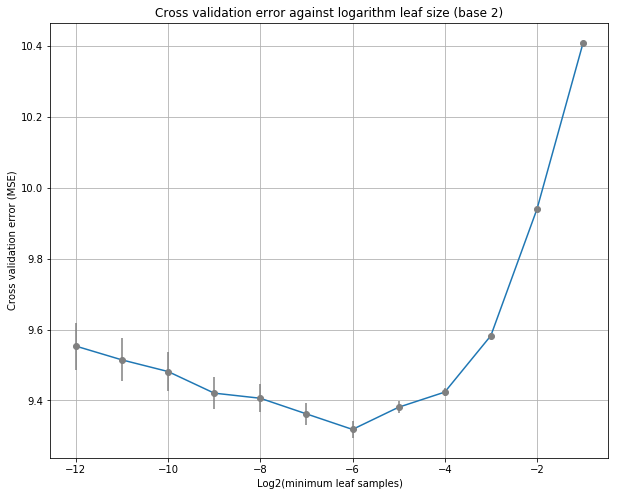

In [443]:
plt.figure(figsize=(10, 8))
plt.plot(
    gs_model_df_ls_group['param_min_samples_leaf_log'],
    -gs_model_df_ls_group['mean']
)
plt.errorbar(
    gs_model_df_ls_group['param_min_samples_leaf_log'],
    -gs_model_df_ls_group['mean'],
    yerr=gs_model_df_ls_group['std'], fmt='o', c='grey')
plt.title('Cross validation error against logarithm leaf size (base 2)')
plt.ylabel('Cross validation error (MSE)')
plt.xlabel('Log2(minimum leaf samples)')
plt.grid()
plt.show()

#### Number of features

In [348]:
gs_parameters_nf = {
    'min_samples_leaf': [0.0157],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'n_estimators': [100]
}

In [350]:
gs_model_df_arr_nf = []
for i in range(0, 100):
    print('Grid search iteration', i + 1)
    gs_model = GridSearchCV(
        RandomForestRegressor(),
        gs_parameters_nf,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=ps,
        error_score=100, n_jobs=1)
    gs_model.fit(X, y.ravel())

    gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
        'param_min_samples_leaf',
        'param_max_features',
        'split0_test_neg_mean_absolute_error',
        'split0_test_neg_mean_squared_error'
    ]]

    gs_model_df_arr_nf.append(gs_model_df)

Grid search iteration 1
Grid search iteration 2
Grid search iteration 3
Grid search iteration 4
Grid search iteration 5
Grid search iteration 6
Grid search iteration 7
Grid search iteration 8
Grid search iteration 9
Grid search iteration 10
Grid search iteration 11
Grid search iteration 12
Grid search iteration 13
Grid search iteration 14
Grid search iteration 15
Grid search iteration 16
Grid search iteration 17
Grid search iteration 18
Grid search iteration 19
Grid search iteration 20
Grid search iteration 21
Grid search iteration 22
Grid search iteration 23
Grid search iteration 24
Grid search iteration 25
Grid search iteration 26
Grid search iteration 27
Grid search iteration 28
Grid search iteration 29
Grid search iteration 30
Grid search iteration 31
Grid search iteration 32
Grid search iteration 33
Grid search iteration 34
Grid search iteration 35
Grid search iteration 36
Grid search iteration 37
Grid search iteration 38
Grid search iteration 39
Grid search iteration 40
Grid sear

In [397]:
gs_model_df_nf = pd.concat(gs_model_df_arr_nf)

gs_model_df_nf_group = \
gs_model_df_nf.groupby('param_max_features')['split0_test_neg_mean_squared_error'].describe()
gs_model_df_nf_group.reset_index(inplace=True)
gs_model_df_nf_group

,param_max_features,count,mean,std,min,25%,50%,75%,max
0,0.1,100.0,-9.466365,0.017858,-9.510893,-9.478789,-9.465732,-9.455213,-9.419297
1,0.2,100.0,-9.404257,0.022405,-9.457757,-9.418177,-9.405373,-9.389471,-9.349303
2,0.3,100.0,-9.376567,0.020767,-9.416427,-9.390529,-9.379435,-9.361327,-9.318929
3,0.4,100.0,-9.359314,0.022606,-9.416668,-9.374004,-9.358601,-9.341632,-9.299494
4,0.5,100.0,-9.347841,0.025439,-9.416599,-9.362528,-9.345438,-9.331068,-9.277283
5,0.6,100.0,-9.342826,0.021770,-9.388213,-9.356773,-9.342836,-9.328706,-9.291317
6,0.7,100.0,-9.339122,0.023683,-9.398264,-9.356575,-9.339691,-9.322553,-9.279541
7,0.8,100.0,-9.331081,0.022429,-9.379821,-9.346467,-9.333672,-9.313621,-9.275745
8,0.9,100.0,-9.319237,0.024541,-9.373538,-9.335982,-9.317447,-9.300338,-9.276185
9,1.0,100.0,-9.318204,0.026873,-9.390360,-9.337078,-9.317399,-9.298283,-9.262168


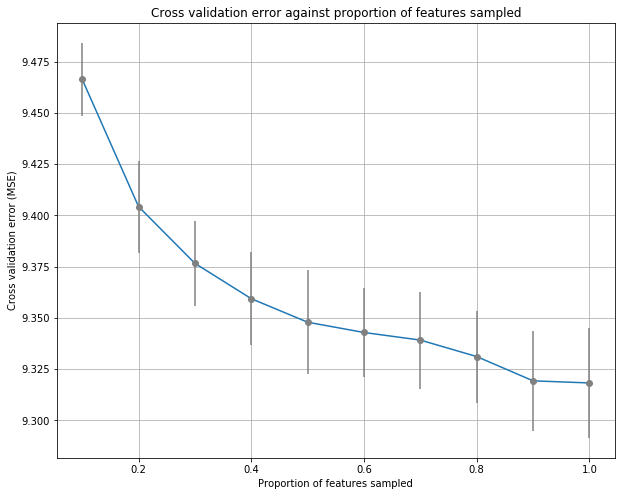

In [444]:
plt.figure(figsize=(10, 8))
plt.plot(
    gs_model_df_nf_group['param_max_features'],
    -gs_model_df_nf_group['mean']
)
plt.errorbar(
    gs_model_df_nf_group['param_max_features'],
    -gs_model_df_nf_group['mean'],
    yerr=gs_model_df_nf_group['std'], fmt='o', color='grey')
plt.title('Cross validation error against proportion of features sampled')
plt.ylabel('Cross validation error (MSE)')
plt.xlabel('Proportion of features sampled')
plt.grid()
plt.show()

#### Number of trees

In [366]:
gs_parameters_nt = {
    'min_samples_leaf': [0.0157],
    'max_features': [0.9],
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
}

In [367]:
gs_model_df_arr_nt = []
for i in range(0, 100):
    print('Grid search iteration', i + 1)
    gs_model = GridSearchCV(
        RandomForestRegressor(),
        gs_parameters_nt,
        scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
        refit=False,
        cv=ps,
        error_score=100, n_jobs=1)
    gs_model.fit(X, y.ravel())

    gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
        'param_min_samples_leaf',
        'param_max_features',
        'param_n_estimators',
        'split0_test_neg_mean_absolute_error',
        'split0_test_neg_mean_squared_error'
    ]]

    gs_model_df_arr_nt.append(gs_model_df)

Grid search iteration 1
Grid search iteration 2
Grid search iteration 3
Grid search iteration 4
Grid search iteration 5
Grid search iteration 6
Grid search iteration 7
Grid search iteration 8
Grid search iteration 9
Grid search iteration 10
Grid search iteration 11
Grid search iteration 12
Grid search iteration 13
Grid search iteration 14
Grid search iteration 15
Grid search iteration 16
Grid search iteration 17
Grid search iteration 18
Grid search iteration 19
Grid search iteration 20
Grid search iteration 21
Grid search iteration 22
Grid search iteration 23
Grid search iteration 24
Grid search iteration 25
Grid search iteration 26
Grid search iteration 27
Grid search iteration 28
Grid search iteration 29
Grid search iteration 30
Grid search iteration 31
Grid search iteration 32
Grid search iteration 33
Grid search iteration 34
Grid search iteration 35
Grid search iteration 36
Grid search iteration 37
Grid search iteration 38
Grid search iteration 39
Grid search iteration 40
Grid sear

In [399]:
gs_model_df_nt = pd.concat(gs_model_df_arr_nt)

gs_model_df_nt['param_n_estimators_log'] = \
gs_model_df_nt['param_n_estimators'].apply(lambda x: math.log(x, 2))

gs_model_df_nt_group = \
gs_model_df_nt.groupby('param_n_estimators_log')['split0_test_neg_mean_squared_error'].describe()
gs_model_df_nt_group.reset_index(inplace=True)
gs_model_df_nt_group

,param_n_estimators_log,count,mean,std,min,25%,50%,75%,max
0,0.0,100.0,-10.262920,0.285947,-10.970777,-10.441826,-10.253504,-10.068569,-9.642288
1,1.0,100.0,-9.781116,0.209132,-10.398329,-9.904058,-9.762032,-9.643346,-9.324754
2,2.0,100.0,-9.559155,0.137487,-9.927231,-9.646588,-9.565401,-9.449866,-9.244818
3,3.0,100.0,-9.425335,0.081486,-9.614534,-9.480274,-9.424977,-9.370031,-9.235884
4,4.0,100.0,-9.367001,0.052482,-9.479744,-9.404835,-9.366347,-9.332019,-9.222682
5,5.0,100.0,-9.344008,0.041116,-9.464649,-9.363683,-9.339513,-9.314139,-9.258091
6,6.0,100.0,-9.328501,0.030283,-9.415052,-9.343635,-9.328780,-9.309961,-9.259871
7,7.0,100.0,-9.321824,0.017944,-9.375722,-9.333468,-9.323647,-9.309035,-9.278080
8,8.0,100.0,-9.315813,0.015195,-9.350094,-9.328017,-9.315788,-9.306333,-9.269965
9,9.0,100.0,-9.313771,0.011706,-9.348584,-9.322312,-9.313726,-9.303589,-9.292319


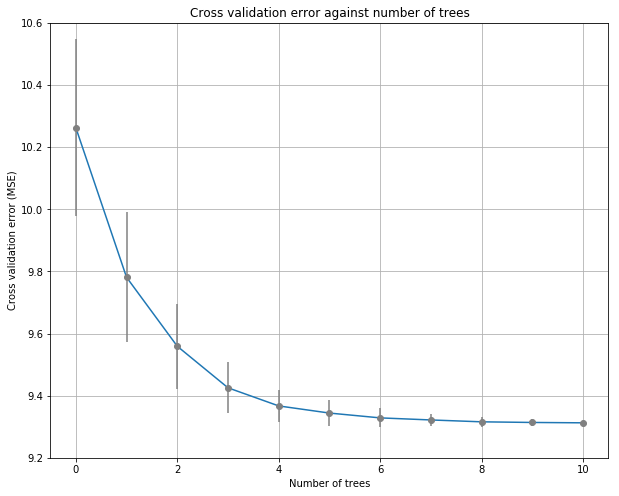

In [449]:
plt.figure(figsize=(10, 8))
plt.plot(
    gs_model_df_nt_group['param_n_estimators_log'],
    -gs_model_df_nt_group['mean']
)
plt.errorbar(
    gs_model_df_nt_group['param_n_estimators_log'],
    -gs_model_df_nt_group['mean'],
    yerr=gs_model_df_nt_group['std'], fmt='o', c='grey')
plt.title('Cross validation error against number of trees')
plt.ylabel('Cross validation error (MSE)')
plt.xlabel('Number of trees')
plt.ylim(9.2, 10.6)
plt.grid()
plt.show()

# Evaluating model

## Random forest

In [434]:
test_loss_arr = []
for i in range(0, 100):
    model = GradientBoostingRegressor(
        criterion='mse',
        min_samples_leaf=0.0175,
        max_features=1.0,
        learning_rate=0.02,
        subsample=0.3,
        n_estimators=200
    )

    model.fit(X_train, y_train.ravel())
    
    # get predictions for test set
    y_pred = model.predict(X_test).flatten()

    # calculate cross entropy loss for test set
    test_loss = (
        mean_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        r2_score(y_test, y_pred)
    )
    test_loss_arr.append(test_loss)

In [442]:
test_loss = \
[np.mean([i[j] for i in test_loss_arr]) for j in range(0, 3)]

test_loss_std = \
[np.std([i[j] for i in test_loss_arr]) for j in range(0, 3)]


test_loss, test_loss_std

([2.185488897712455, 9.312998931872741, 0.10510629583248025],
 [0.0020690617414785926, 0.011219919706621012, 0.0010781312851177473])

In [436]:
test_loss_full_arr = []
for i in range(0, 100):
    model_full = RandomForestRegressor(
        criterion='mse',
        min_samples_leaf=0.0156,
        max_features=0.9,
        n_estimators=500
    )

    model_full.fit(X, y.ravel())
    
    # get predictions for test set
    y_pred_full = model_full.predict(X).flatten()

    # calculate cross entropy loss for test set
    test_loss_full = (
        mean_absolute_error(y, y_pred_full),
        mean_squared_error(y, y_pred_full),
        r2_score(y, y_pred_full)
    )
    test_loss_full_arr.append(test_loss_full)

In [437]:
test_loss_full = \
[np.mean([i[j] for i in test_loss_full_arr]) for j in range(0, 3)]

test_loss_full

[2.0324275937117515, 7.784884412941644, 0.18640978895516627]

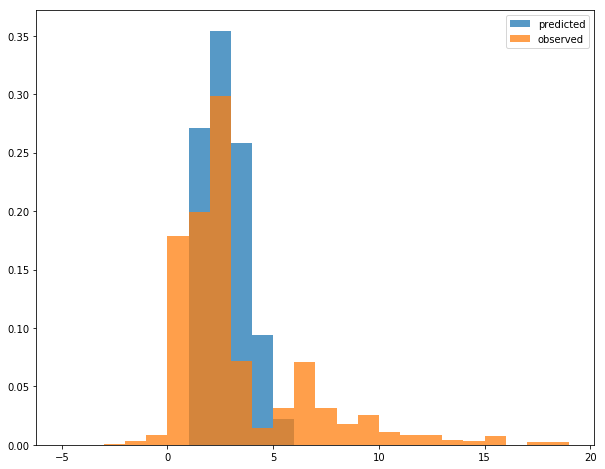

In [438]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

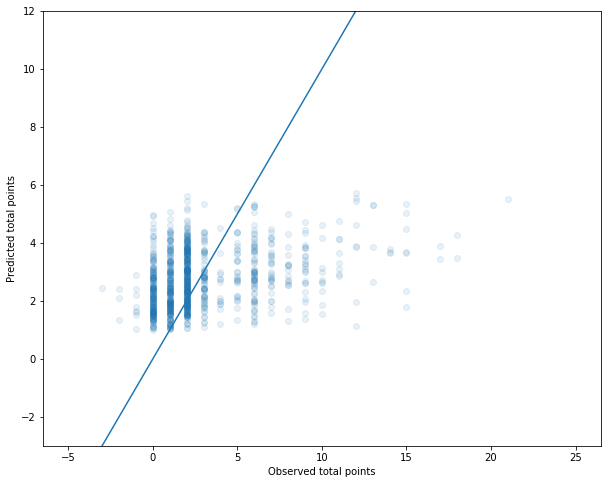

In [439]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

In [451]:
model.feature_importances_


80

In [458]:
pd.DataFrame(
    list(zip(X.design_info.column_names, model.feature_importances_)),
    columns=['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
47,value,0.252259
77,rolling_avg_goals_scored_opposition_team,0.112414
79,expected_total_points_against_opposition_team_...,0.081379
75,rolling_avg_minutes_element_p3,0.070401
48,rolling_avg_total_points_element,0.045150
78,rolling_avg_goals_conceded_opposition_team,0.044288
66,rolling_avg_attempted_passes_element,0.032591
57,rolling_avg_clearances_blocks_interceptions_el...,0.032382
54,rolling_avg_key_passes_element,0.032235
59,rolling_avg_target_missed_element,0.029033


## Summary

In [440]:
pd.DataFrame([
    ('Random Forest', test_loss[0], test_loss[1], test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Random Forest,2.185489,9.312999,0.105106


In [441]:
pd.DataFrame([
    ('Random Forest', test_loss_full[0], test_loss_full[1], test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Random Forest,2.032428,7.784884,0.18641
